In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.optimize import curve_fit
from scipy import stats,special
import math

# Transient Absorption Spectroscopy: Data Analysis


## 1. Signal processing

Spectra are generated by the laser setup at 1kHz and is shone onto a CCD camera that typically gives 4000 data points for each pixel over the space of 4 seconds. These points have low frequency noise resulting from dust on optics, scattering, defects, etc. The noise therefore needs to be filtered out from rest of the data, this is done by binning the data and setting some exclusion parameters around the mode of the binned data (the most populated bin). The data is then reevaluated and if required refiltered.

In this notebook we generate a gaussian distrubution around a mean value and randomly add noise to around 25% of the shots. We then filter the data and look at the effect on the signal to noise ratio (S/N), mean values and standard deviations.

In [2]:
# Generates a random distribution with random noise
def gen(size,l,u,sd,loc):
    np.random.seed(seed=3613)
    dist = np.empty([size])
    for i in range(size):
        dist[i] = np.random.normal(scale=sd,size=1,loc=loc) if np.random.uniform(0,1) > 0.25 else np.random.normal(scale=5*sd,size=1,loc=loc) - np.random.uniform(u,l,size=1)
    return dist

#Bins data
def binned(b,dist): 
    bins = np.linspace(min(dist),max(dist), num = b)
    inds = np.digitize(dist,bins,right=True)
    data = [bins[i-1] for i in inds]
    return data

#Get filter conditions
def filter_con(data):
    val, count = np.unique(data, return_counts=True)
    m = count[np.where(count == max(count))]
    P = (len(data)-m)/len(data)
    n = math.sqrt(2)*(1/(special.erf(P)))
    upper_tolerance = val[np.where(count == max(count))] + n*np.std(data)
    lower_tolerance = val[np.where(count == max(count))] - n*np.std(data)
    return lower_tolerance,upper_tolerance,m

#Filter data 
def fltr(data,l,u):
    dtemp = []
    for d in data:
        if (d > l) and (d < u):
            dtemp.append(d)
    dt = np.array(dtemp)
    return dt

#Signal to noise ratio
def stn(data):
    return (np.mean(data))/(np.std(data))

In [3]:
bins = 100 #Number of bins
loc = 50 #true value
range_max = 25
range_min = -15
size = 4000 #size of data
sd=3 #standard deviation of gaussian pulse

#Generating data
data_O = gen(size,range_min,range_max,sd,loc)

In [4]:
#Data fitering 
data_s = data_O
m=size
while m>0.05*size:
    da   = binned(bins,data_s)
    l,u,m  = filter_con(da)
    data_s = fltr(data_s,l,u) 

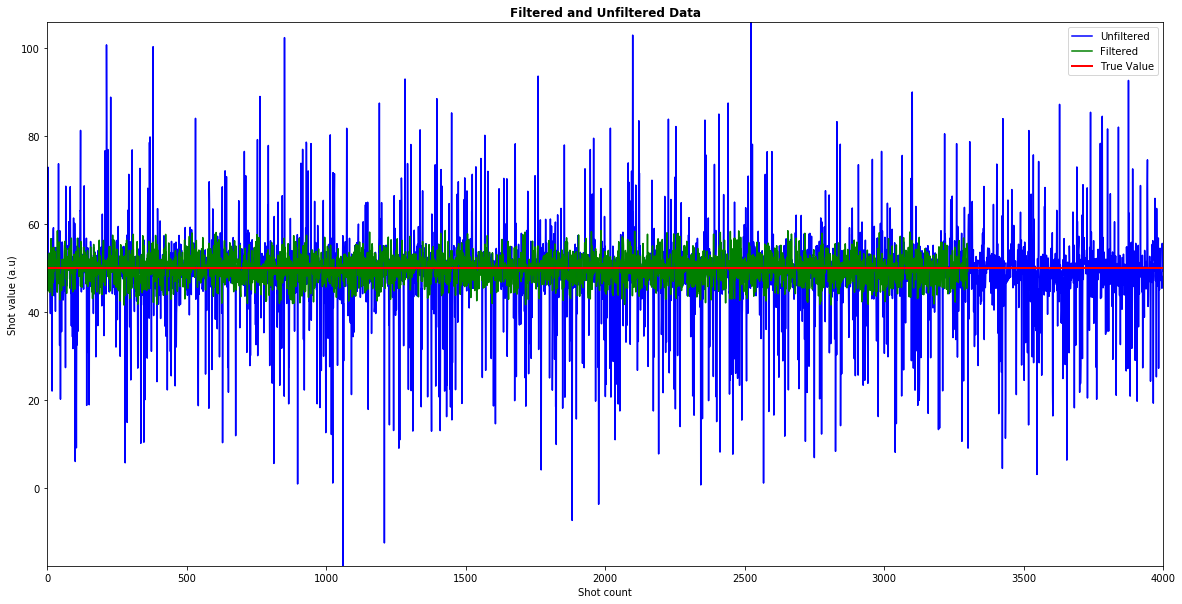

The S/N: 
 	unfiltered data:	4.7845
	filtered data:  	15.8059 




In [5]:
plt.figure(figsize=(20,10))
plt.plot(data_O,color='b',label='Unfiltered')
plt.plot(data_s,color='g',label='Filtered')
plt.axhline(y=loc,color='red',linewidth = 2,label='True Value')
plt.gca().set_ylim(min(data_O),max(data_O))
plt.gca().set_xlim(0,size)
plt.ylabel('Shot value (a.u)')
plt.xlabel('Shot count')
plt.title('Filtered and Unfiltered Data',weight="bold")
plt.legend()
plt.show()
print('The S/N: \n \tunfiltered data:\t{:.4f}'.format(stn(data_O)))
print('\tfiltered data:  \t{:.4f} \n\n'.format(stn(data_s)))

_**Figure 1.1** Figure showing the filtered (green) and unfiltered data (blue) the data is shown as the shot value against the shot count. The signal to noise ratio has is printed with a drastic increase in filtered data._

We see that in figure 1.1 the filtered data has a visually cleaner signal but with a lower shot count as some of the outlying points have been removed. The S/N ratio is drastically improved by the filtering.

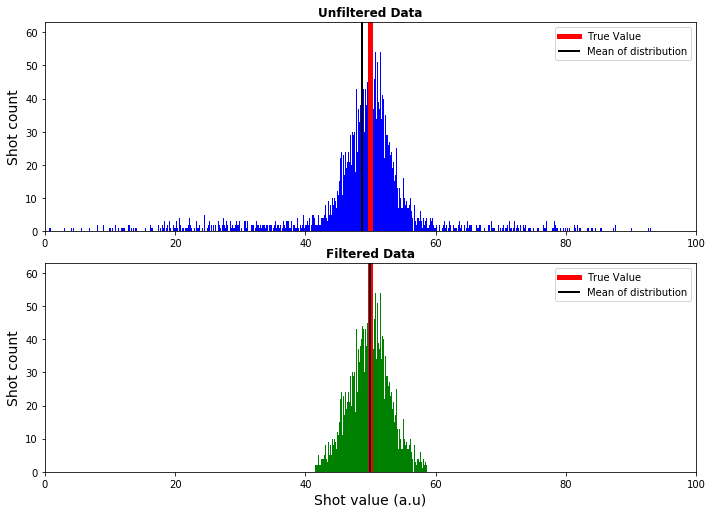


The difference between the true value and the mean

	unfiltered data is : 	 1.329
	standard deviation of: 	 10.173
	filtered data is : 	 0.1000
	standard deviation of: 	 3.157 




In [6]:
binsize = np.arange(min(data_O),max(data_O),0.1)

plt.figure(figsize=(10,7))
plt.subplot(211)
plt.tight_layout()
plt.axvline(x=loc,color='red',linewidth = 5,label='True Value')
plt.axvline(x=np.mean(data_O),color='black',linewidth = 2,label='Mean of distribution')
plt.hist(data_O,color='b',bins=binsize)
plt.gca().set_xlim(right=100,left=0)
plt.ylabel('Shot count',fontsize=14)
plt.title('Unfiltered Data',weight="bold")
plt.legend()

plt.subplot(212)
plt.tight_layout()
plt.axvline(x=loc,color='red',linewidth = 5,label='True Value')
plt.axvline(x=np.mean(data_s),color='black',linewidth = 2,label='Mean of distribution')
plt.hist(data_s,color='g',bins=binsize)
plt.gca().set_xlim(right=100,left=0)

plt.xlabel('Shot value (a.u)',fontsize=14)
plt.ylabel('Shot count',fontsize=14)
plt.title('Filtered Data',weight="bold")
plt.legend()
plt.savefig('signals.png',format='png')
plt.show()

print('\nThe difference between the true value and the mean\n\n\tunfiltered data is : \t {:.3f}'.format(loc - np.mean(data_O)))
print('\tstandard deviation of: \t {:.3f}'.format(np.std(data_O)))
print('\tfiltered data is : \t {:.4f}'.format(loc - np.mean(data_s)))
print('\tstandard deviation of: \t {:.3f} \n\n'.format(np.std(data_s)))

_**Figure 1.2** Figure showing the unfiltered (top) and filtered data (bottom). Plotted for both are the true value (red) and the calculated mean vlaue. Printed is the difference of the mean from the true value along with the corresponding standard deviations of the distributions for both histagrams._

Figure 1.2 shows a visually cleaner signal without decreasing the strength arround the true value. We see that the difference between the mean and true values has improved along with how the standard deviation corresponds to the set value.

Each filtered distribution of shots is then averaged and put into a matrix with reference to its wavelength and the timedelay at which it was taken (M[wavelength,timedelay]). The 2D spectral matracies are remeasured between 4 and 20 (scans) times depending on the signal strength in order to get a cleaner averaged signal.

## 2. Production of Spectra

### 2.1 Averaging and background subtraction
The spectral matracies are loaded and stacked by scans M[scans,wavelength,timedaly] and then averaged down the 0th axis (scans) (data_raw). Time (containing the timedelays, t) and wavelength (containing the spectral points, w) arrays are extracted from the matrix.

In [7]:
data_raw = np.stack([np.loadtxt(f, delimiter='\t') for f in glob.glob('Data/*.txt')],0)
t = np.array(data_raw[0,0,1:])
w = data_raw[0,1:,0]
print('Shape of data:\n data_raw \t= \t' + str(data_raw.shape) + '\n t \t\t= \t' + str(t.shape)+ '\n w \t\t= \t'+ str(w.shape))

Shape of data:
 data_raw 	= 	(8, 528, 187)
 t 		= 	(186,)
 w 		= 	(527,)


In [8]:
#Data averaged over the 8 scans.
data_raw = np.mean(data_raw[:,1:,1:],axis=0)
print('Shape of data:\n data_raw \t= \t' + str(data_raw.shape))

Shape of data:
 data_raw 	= 	(527, 186)


As seen in figure 1 there is a strong background singal, this is caused by scattering from the laser pulse that excited the sample. This background scattering is reasonably consistant on the nanosecond timescale and so can be seen even at negative timedelays. An average of the negative time spectra is taken and then subtracted from all spectra at each timee delay resulting in a clean spectral matrix (data).

In [9]:
#Creating the background spectera
data_neg = np.mean(data_raw[:,np.asarray(np.where(t<0)).flatten()],axis=1)

In [10]:
#Subtracting the background spectra
data_raw_t = np.array([data_raw[:,ts] - data_neg[:] for ts in range(len(t))])
data = np.transpose(data_raw_t)
print('Shape of data:\n data \t= \t' + str(data.shape))

Shape of data:
 data 	= 	(527, 186)


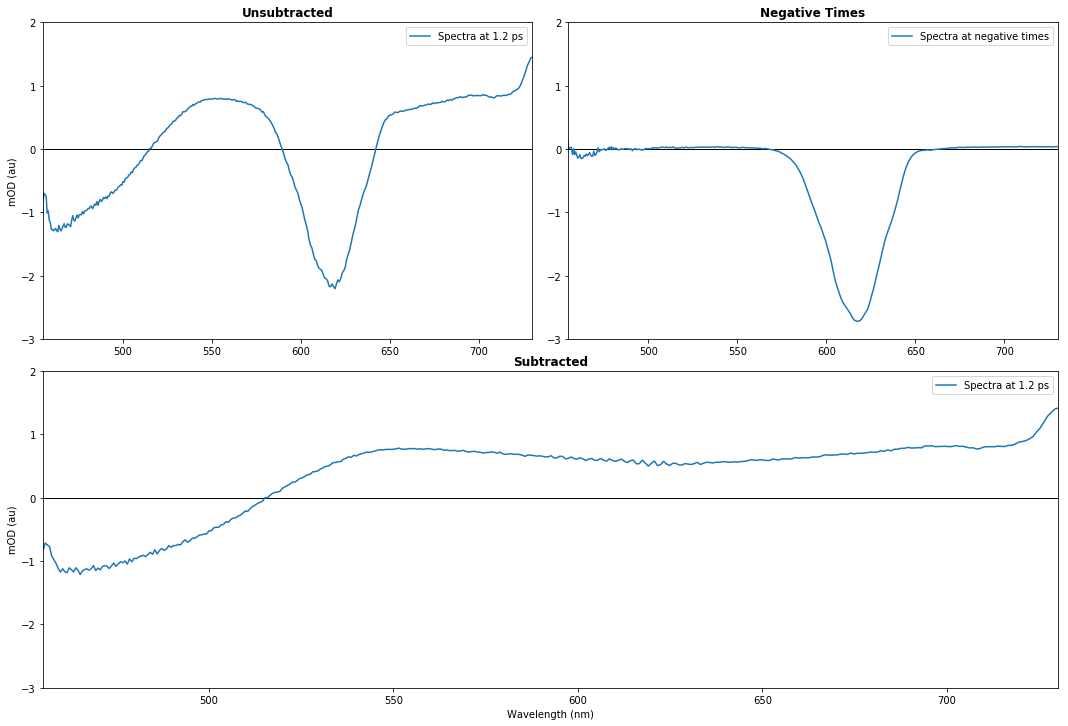

In [11]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.tight_layout()
plt.axhline(y=0,color='black',linewidth = 1)
plt.plot(w,np.transpose(data_raw[:,50]),label='Spectra at 1.2 ps')
plt.gca().set_ylim(-3,2)
plt.gca().set_xlim(455,730)
plt.ylabel('mOD (au)')
plt.title('Unsubtracted',weight="bold")
plt.legend()

plt.subplot(222)
plt.tight_layout()
plt.axhline(y=0,color='black',linewidth = 1)
plt.plot(w,data_neg,label='Spectra at negative times')
plt.gca().set_ylim(-3,2)
plt.gca().set_xlim(455,730)
plt.title('Negative Times',weight="bold")
plt.legend()

plt.subplot(212)
plt.tight_layout()
plt.axhline(y=0,color='black',linewidth = 1)
plt.plot(w,data[:,50],label='Spectra at 1.2 ps')
plt.gca().set_ylim(-3,2)
plt.gca().set_xlim(455,730)
plt.xlabel('Wavelength (nm)')
plt.ylabel('mOD (au)')
plt.title('Subtracted',weight="bold")
plt.legend()
plt.show()

_**Figure 2.1:** Figure showing the spectra at 1.2 ps without the background scattering subtracted (top left), the background scattering seen at times where no spectra is present (negative timedelays, tope right) and the spectra at 1.2 ps after the background scattering has been subtracted._

### 2.2 Chrip Correction

In order to maintain temporal resolution the spectra are taken in a single shot by a braud 'white light' pulse ranging from 450 nm to 730 nm. This white light goes through several optics (mirrors, filters, lenses etc.) and because the refractive index of these optics is dependant on the wavelength of light passing through, the pules is lengthened and becomes chirped. When a pulse is said to be chirped this means that the wavelengths are not equally distributed thoughout the pulse and so the higher frequency parts (lower wavelength) of the pulse arrive at the begining and the lower frequency (longer wavelengths) at the end of the pulse. When a spectra is measured with a chirped white light pulse the onset of the spectra is different for each wavelength (as seen in Figure 2) and this can be corrected for. 

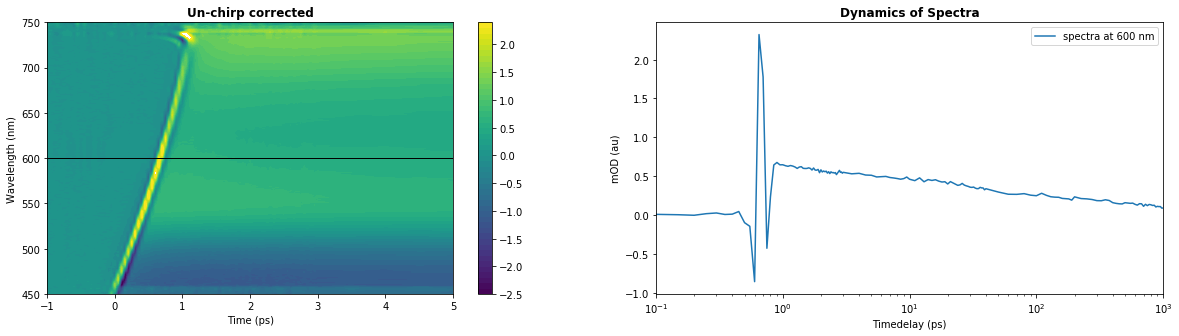

In [12]:
plt.figure(figsize=(20,5))

plt.subplot(121)
X,Y = np.meshgrid(t,w)
plt.contourf(X,Y,data,levels=np.arange(-2.5,2.5,0.1))
plt.colorbar()
plt.axhline(y=600,color='black',linewidth = 1)
plt.gca().set_xlim(-1,5)
plt.gca().set_ylim(450,750)
plt.xlabel('Time (ps)')
plt.ylabel('Wavelength (nm)')
plt.title('Un-chirp corrected',weight="bold")

plt.subplot(122)
plt.plot(t,data[211,:],label='spectra at 600 nm')
plt.gca().set_xlim(0.1,1000)
plt.xscale('log')
plt.xlabel('Timedelay (ps)')
plt.ylabel('mOD (au)')
plt.title('Dynamics of Spectra',weight="bold")
plt.legend()
plt.show()

_**Figure 2.2:** Figure showing 3D representation of transient spectra which has not yet been corrected for chirp (left) and the dynamics of the transient absorption spectra at 600 nm (right, and represented in left figure by horizontal black line)._

As seen in both plots in figure 2, the onset of the spectra is the maximum of the signal. So by finding at what time the maximum point of the signal is at each wavelength we can characterize and then correct for the chirp in the spectra.

In [13]:
times = np.array([t[np.where(data[i,:] == max(data[i,:]))] for i in range(len(w))]).flatten()
grad = np.gradient(np.gradient(times))
for i in range(int(len(grad)/2),len(grad)):
    if np.abs(grad[i])>(0.001*(np.median(grad)+np.std(grad))):
        upper = i
        break
        
for i in range(int(len(grad)/2),0,-1):
    if np.abs(grad[i])>(0.001*(np.median(grad)+np.std(grad))):
        lower = i
        break
        
def func(x,y0,A,x0,tau):
    return y0 + A*np.exp(-(x-x0)/tau)

p0 = [0,-1,max(w[lower:upper]),1]
popt, pcov = curve_fit(func, w[lower:upper],times[lower:upper],p0,maxfev = 10000)

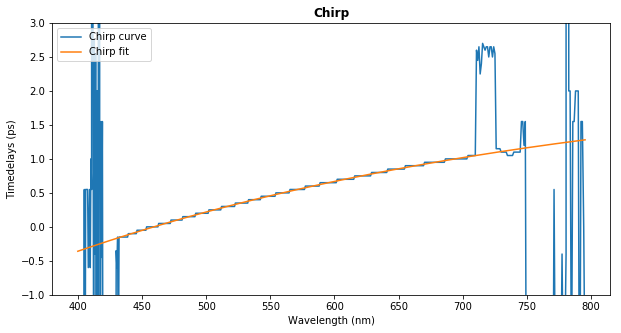

In [14]:
plt.figure(figsize=(10,5))
plt.plot(w,times, label='Chirp curve')
plt.plot(w,func(w,*popt),label='Chirp fit')
plt.gca().set_ylim(-1,3)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Timedelays (ps)')
plt.title('Chirp',weight="bold")
plt.legend(loc='upper left')
plt.show()

_**Figure 2.3:** The chirp curve at each wavelength (blue) along with the exponential fit (orange)._

The time at which the spectral onset occurs for each wavelength is plotted (Figure 3) and then fitted with an exponentail function. The fit parameters are used to construct corrected time arrays for each wavelength (put into a matrix, td). The corrected data is then interpolated back onto the origional time array resulting in a data set where the spectral onset at each wavelength happens at time zero.

In [15]:
td = np.zeros(data.shape)
data_i = np.zeros(data.shape)
for i in range(len(w)):
    zero = func(w[i],*popt)
    for j in range(len(t)):
        td[i,j] = t[j] - zero
    data_i[i,:] = np.interp(t,td[i,:],data[i,:])

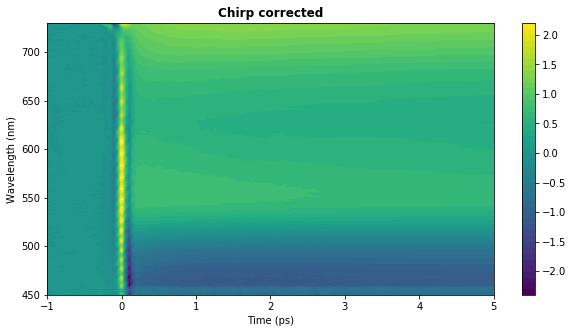

In [16]:
plt.figure(figsize=(10,5))

#plt.subplot(121)
plt.contourf(X,Y,data_i,levels=np.arange(-2.4,2.3,0.1))
plt.colorbar()
plt.gca().set_xlim(-1,5)
plt.gca().set_ylim(450,730)
plt.xlabel('Time (ps)')
plt.ylabel('Wavelength (nm)')
plt.title('Chirp corrected',weight="bold")
plt.show()

_**Figure 2.4** Figure showing 3D representation of transient spectra which has been corrected for chirp._

### 2.3 Data Representation

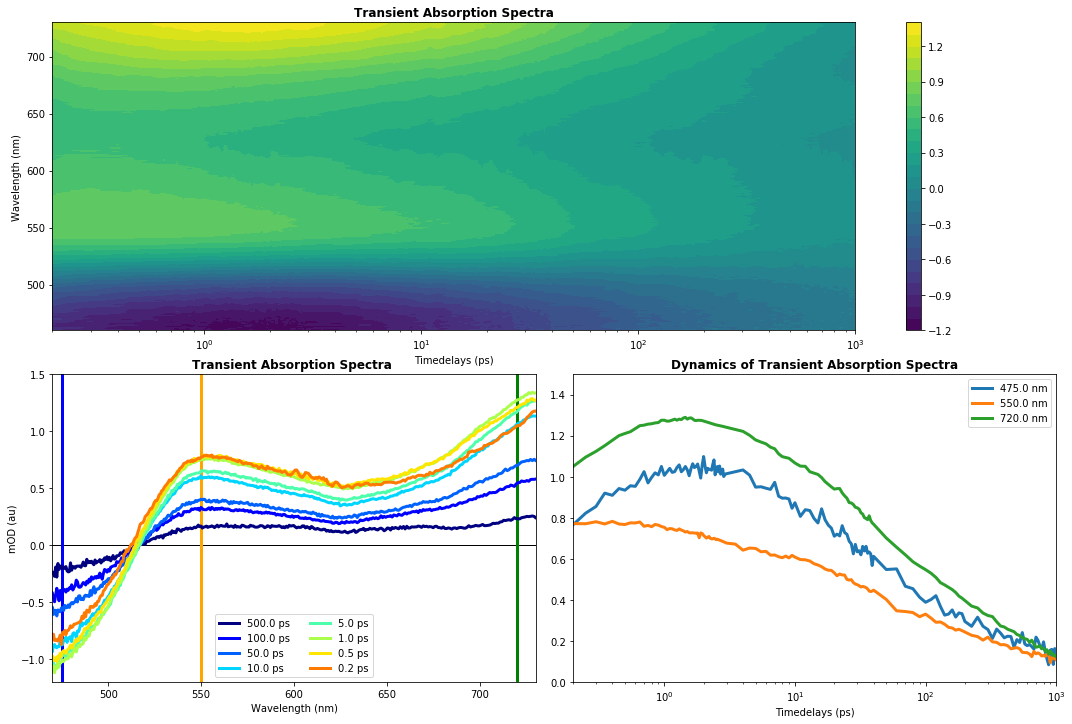

In [17]:
tds = np.array([np.where(t==i) for i in (0.2,0.5,1,5,10,50,100,500,1000)]).flatten()
tds = tds[:-1]

plt.figure(figsize=(15,10))

plt.subplot(223)
plt.tight_layout()
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
plt.axhline(y=0,color='black',linewidth = 1)
plt.axvline(x=475,color='b',linewidth = 3)
plt.axvline(x=550,color='orange',linewidth = 3)
plt.axvline(x=720,color='g',linewidth = 3)
for ts in reversed(tds):
    plt.plot(w,data_i[:,ts],label=str(float(t[ts]))+' ps',linewidth = 3,color=next(colors))
plt.gca().set_ylim(-1.2,1.5)
plt.gca().set_xlim(470,730)
plt.xlabel('Wavelength (nm)')
plt.ylabel('mOD (au)')
plt.title('Transient Absorption Spectra ',weight="bold")
plt.legend(ncol=2)

#wls = np.array([np.where(np.around(w)==i) for i in range(500,700,50)]).flatten()

plt.subplot(224)
plt.tight_layout()
#for i in wls:
for i in (390,278,74):
    plt.plot(t,np.abs(data_i[i,:]),linewidth = 3,label=str(float(np.around(w[i],0)))+' nm')
plt.axhline(y=0,color='black',linewidth = 1)
plt.gca().set_xlim(0.2,1000)
plt.gca().set_ylim(0,1.5)
plt.xscale('log')
plt.xlabel('Timedelays (ps)')
#plt.ylabel('mOD (au)')
plt.title('Dynamics of Transient Absorption Spectra',weight="bold") 
plt.legend()

plt.subplot(211)
plt.tight_layout()
plt.contourf(X,Y,data_i,levels=np.arange(-1.2,1.5,0.1))
plt.colorbar()
plt.gca().set_xlim(0.2,1000)
plt.gca().set_ylim(460,730)
plt.xscale('log')
plt.xlabel('Timedelays (ps)')
plt.ylabel('Wavelength (nm)')
plt.title('Transient Absorption Spectra',weight="bold")
plt.show()


_**Figure 2.5** Figure showing 3D representation of transient spectra with a log timedelay axis (top), the transient absorption spectra at different times (bottom left) and the dynamics of the three major peaks in the spectra (bottom right)._

## 3. Spectral Analysis

### 3.1 Global Analysis

Global Analysis takes the dynamics of the spectra at each time delay and fits each of them while keeping some of the variables linked over each fit. The fit function is the convolution of a Gaussian and between 1 and 4 exponentials.

The fit function for the convolution of a Gaussian and two exponentials:
\begin{equation*}
f(t) = y_0 + 0.5A_1e^\frac{-(t-t_0)}{\tau_1}e^\frac{-w^2}{4\tau_1^2}[1+erf(\frac{t-t_0-\frac{w^2}{2\tau_1}}{w})] + 0.5A_2e^\frac{-(t-t_0)}{\tau_2}e^\frac{-w^2}{4\tau_2^2}[1+erf(\frac{t-t_0-\frac{w^2}{2\tau_2}}{w})]
\end{equation*}

With $y_0$ being the background, $A$ the amplitude of the exponential, $t_0$ the time zero, $w$ the width of the Gaussian and $\tau$ the time constant. During the fitting the time constants $\tau_1$ and $\tau_2$ are kept linked so that the best fit is found while the time constants stay equivalent. The width of the Gaussian $w$ is also kept linked as well as the $t_0$ (which hould be exactly zero if the chirp correction was successful).

The amplitudes of each exponential are then plotted against wavelength to help seperate components of the spectra by their decay constants. This allows us to not only see seperated spectral components but also ones that are linked in their growth or decay.

### 3.2 Spectral Decomposition

Spectral Decomposition takes the known spectra of the components that make up a TA spectrum and uses them to do a  nonnegative least-squares curve fitting on each time delay of the spectra. The weights or amplitudes of the fit are then used to reconstruct the spectra and to get the dynamics of each individual component.

The nonnegative least-squares problem takes the form:

\begin{equation*}
min_x ||C\cdot x-d||_2^2, where\;\;x\geq0
\end{equation*}

Where $C$ is the component and $d$ is the spectra that is being fit, $x$ then gives the weight/amplitude that holds the dynamics of the component in time.

The MATLAB code looks like this:

In [18]:
Data=load('Data.txt');     #loads data                        
wavelength=load('wavelength.txt');
timedelay=load('timedelay.txt');
Comp_1=load('Comp_1.txt'); #loads premade components 
Comp_2=load('Comp_2.txt'); #loads premade components

B = [Comp_1; Comp_2];

for i=1:length(timedelay)
    c(i,:) = lsqnonneg(B,Data(i,:)); #Solves the nonnegative least-square problem

    y(i,:) = c(i,1)*Comp_1 + c(i,2)*Comp_2; #Reconstructs spectrum
    Component_1(i,:)= c(i,1)*Comp_1; #Reconstructs weighted component
    Component_2(i,:)= c(i,2)*Comp_2; #Reconstructs weighted component
end

SyntaxError: invalid syntax (<ipython-input-18-a1f82506c3cc>, line 7)

### 3.3 Future Work

Everything up to the spectral analysis has been automated so for (see code above), however the Global Analysis and Spectral Decomposition still require a large amount of personal experience with the data. With Global Analysis the more exponentials that are put into the fit the easier the fit is, however this is often not linked to real physical processes. The components that are put into the Spectral decomposition also require a lot of experience to see what should be put in as a component and what should not.

The future plan would be to automate these difficult processes using machine learning to be able to create a standardised and rigerous process for data analysis in the field and so that data is less easily maniulated by choice of components etc. 